<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/data-science-bookcamp/case-study-3--disease-outbreaks/01_clustering_data_into_groups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clustering data into groups

Clustering is the process of organizing data points into conceptually meaningful groups.

What makes a given group `conceptually meaningful`? 

There is no easy answer to that question. The usefulness of any clustered output is dependent on the task we’ve been assigned.

##Setup

In [1]:
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
from scipy import stats
import math

from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

import seaborn as sns
import matplotlib.pyplot as plt

##Using centrality to discover clusters

Intuitively, all data points in a single group should cluster around one
central value. Meanwhile, the measurements in two divergent groups should cluster around two different means. 

Thus, we can utilize centrality to distinguish between two divergent groups.

Let’s simulate the scattering numerically. We’ll treat each bull’s-eye location as a
2D coordinate. Darts are randomly flung at that coordinate.

In [2]:
# Modeling dart coordinates using two normal distributions
np.random.seed(0)

mean = 0
variance = 2

x = np.random.normal(mean, variance ** 0.5)
y = np.random.normal(mean, variance ** 0.5)
print(f"The x coordinate of a randomly thrown dart is {x:.2f}")
print(f"The y coordinate of a randomly thrown dart is {y:.2f}")

The x coordinate of a randomly thrown dart is 2.49
The y coordinate of a randomly thrown dart is 0.57


Let’s simulate 5,000 random darts tossed at the bull’s-eye positioned at `[0, 0]`. 

We also simulate 5,000 random darts tossed at a second bull’s-eye, positioned at `[0, 6]`.

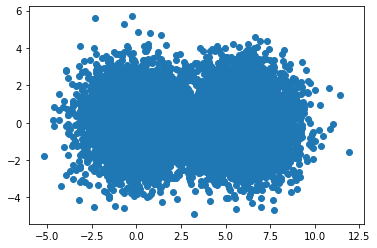

In [3]:
# Simulating randomly thrown darts
np.random.seed(1)

bulls_eye1 = [0, 0]
bulls_eye2 = [6, 0]
bulls_eyes = [bulls_eye1, bulls_eye2]

x_coordinates, y_coordinates = [], []
for bulls_eye in bulls_eyes:
  for _ in range(5000):
    x = np.random.normal(bulls_eye[0], variance ** 0.5)
    y = np.random.normal(bulls_eye[1], variance ** 0.5)
    x_coordinates.append(x)
    y_coordinates.append(y)

plt.scatter(x_coordinates, y_coordinates)
plt.show()

Let’s assign each dart to its nearest bull’s-eye. 

We measure dart proximity using Euclidean distance, which is the standard straight-line distance between two points.

In [4]:
# Assigning darts to the nearest bull’s-eye
def nearest_bulls_eye(dart):
  distances = [euclidean(dart, bulls_eye) for bulls_eye in bulls_eyes]
  return np.argmin(distances)

In [5]:
darts = [[0, 1], [6, 1]]
for dart in darts:
  index = nearest_bulls_eye(dart)
  print(f"The dart at position {dart} is closest to bulls-eye {index}")

The dart at position [0, 1] is closest to bulls-eye 0
The dart at position [6, 1] is closest to bulls-eye 1


Now we apply nearest_bulls_eye to all our computed dart coordinates.

In [23]:
# Coloring darts based on the nearest bull’s-eye
def color_by_cluster(darts):
  nearest_bulls_eyes = [nearest_bulls_eye(dart) for dart in darts]
  for bs_index in range(len(bulls_eyes)):
    # Selects the darts most proximate to bulls_eyes[bs_index]
    selected_darts = [darts[i] for i in range(len(darts)) if bs_index == nearest_bulls_eyes[i]]
    # Separates the x and y coordinates of each dart by transposing an array of selected darts.
    x_coordinates, y_coordinates = np.array(selected_darts).T
    plt.scatter(x_coordinates, y_coordinates, color=["g", "k", "r"][bs_index])
  plt.show()

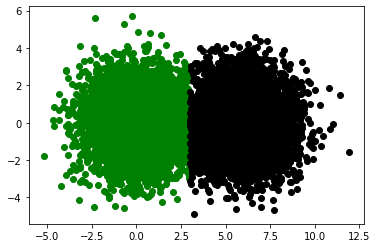

In [7]:
# Combines the separate coordinates of each dart into a single list of x and y coordinates
darts = [[x_coordinates[i], y_coordinates[i]] for i in range(len(x_coordinates))]
color_by_cluster(darts)

How would we identify such clusters if no central coordinates were provided?

Well, one primitive strategy is to
simply guess the location of the bull’s-eyes.

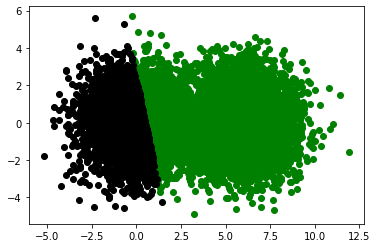

In [8]:
# Assigning darts to randomly chosen centers
bulls_eyes = np.array(darts[:2])  # Randomly selects the first two darts to be our representative bull’s-eyes
color_by_cluster(darts)

In [9]:
# Assigning darts to centers based on means
def update_bulls_eyes(darts):
  updated_bulls_eyes = []
  nearest_bulls_eyes = [nearest_bulls_eye(dart) for dart in darts]
  for bs_index in range(len(bulls_eyes)):
    # Selects the darts most proximate to bulls_eyes[bs_index]
    selected_darts = [darts[i] for i in range(len(darts)) if bs_index == nearest_bulls_eyes[i]]
    # Separates the x and y coordinates of each dart by transposing an array of selected darts.
    x_coordinates, y_coordinates = np.array(selected_darts).T
    # Takes the mean of the x and y coordinates for all the darts assigned to a given bull’s-eye
    mean_center = [np.mean(x_coordinates), np.mean(y_coordinates)]
    updated_bulls_eyes.append(mean_center)
  return updated_bulls_eyes

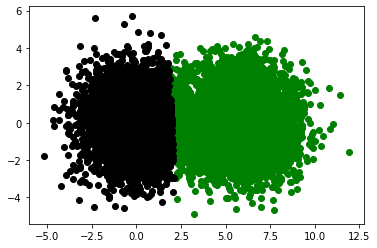

In [10]:
bulls_eyes = update_bulls_eyes(darts)
color_by_cluster(darts)

The cluster’s centers still appear a little off. 

Let’s remedy the results by repeating
the mean-based centrality adjustment over 10 additional iterations.

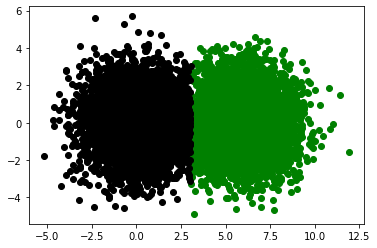

In [11]:
# Adjusting bull’s-eye positions over 10 iterations
for i in range(10):
  bulls_eyes = update_bulls_eyes(darts)
color_by_cluster(darts)

We have essentially replicated the
K-means clustering algorithm, which organizes data using centrality.

##K-means clustering algorithm

The K-means algorithm assumes that inputted data points swirl around K different centers.
Each central coordinate is like a hidden bull’s-eye surrounded by scattered data points. 

The purpose of the algorithm is to uncover these hidden central coordinates.

In [12]:
# K-means clustering using scikit-learn
cluster_model = KMeans(n_clusters=2)
assigned_bulls_eyes = cluster_model.fit_predict(darts)

print(f"Bull's-eye assignments:")
print(assigned_bulls_eyes)

Bull's-eye assignments:
[0 0 0 ... 1 1 1]


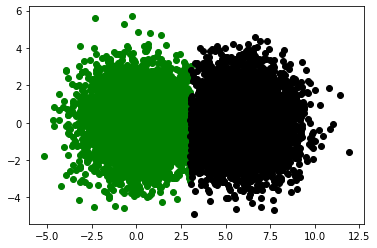

In [13]:
# Plotting K-means cluster assignments
for bs_index in range(len(bulls_eyes)):
  # Selects the darts most proximate to assigned_bulls_eyes[bs_index]
  selected_darts = [darts[i] for i in range(len(darts)) if bs_index == assigned_bulls_eyes[i]]
  # Separates the x and y coordinates of each dart by transposing an array of selected darts.
  x_coordinates, y_coordinates = np.array(selected_darts).T
  plt.scatter(x_coordinates, y_coordinates, color=["g", "k"][bs_index])
plt.show()

Our clustering model has located the centroids in the data. 

Now we can reuse these
centroids to analyze new data points that the model has not seen before.

In [14]:
# Using cluster_model to cluster new data
def cluster_data(new_darts):
  new_bulls_eye_assignments = cluster_model.predict(new_darts)
  for i, dart in enumerate(new_darts):
    bulls_eye_index = new_bulls_eye_assignments[i]
    print(f"Dart at {dart} is closest to bull's-eye {bulls_eye_index}")

In [15]:
new_darts = [[500, 500], [-500, -500]]
cluster_data(new_darts)

Dart at [500, 500] is closest to bull's-eye 1
Dart at [-500, -500] is closest to bull's-eye 0


In [16]:
new_darts = [[0, 1], [6, 1]]
cluster_data(new_darts)

Dart at [0, 1] is closest to bull's-eye 0
Dart at [6, 1] is closest to bull's-eye 1


In [17]:
new_darts = [[0.5, 1.5], [6.5, 1.5]]
cluster_data(new_darts)

Dart at [0.5, 1.5] is closest to bull's-eye 0
Dart at [6.5, 1.5] is closest to bull's-eye 1


In [18]:
new_darts = [[8.5, 3.5], [-3.5, 2.5]]
cluster_data(new_darts)

Dart at [8.5, 3.5] is closest to bull's-eye 1
Dart at [-3.5, 2.5] is closest to bull's-eye 0


###The elbow method

We can, however, estimate an
appropriate value for $K$ using a technique known as the elbow method.

The elbow method depends on a calculated value called inertia, which is the sum of
the squared distances between each point and its closest K-means center.

Basically, inertia estimates total
dispersion around our K computed means.

By estimating dispersion, we can determine whether our K value is too high or too low.

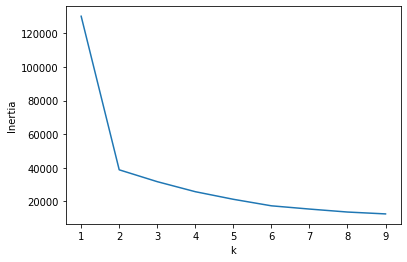

In [21]:
# Plotting the K-means inertia
k_values = range(1, 10)

inertia_values = [KMeans(k).fit(darts).inertia_ for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

We can find out by adding an additional bull’s-eye to our dart-throwing simulation. 

After we increase the cluster count to 3, we regenerate our inertia plot.

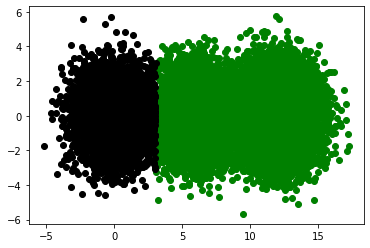

In [24]:
# Plotting inertia for a 3-dartboard simulation
new_bulls_eye = [12, 0]
for _ in range(5000):
  x = np.random.normal(new_bulls_eye[0], variance ** 0.5)
  y = np.random.normal(new_bulls_eye[1], variance ** 0.5)
  darts.append([x, y])

color_by_cluster(darts)

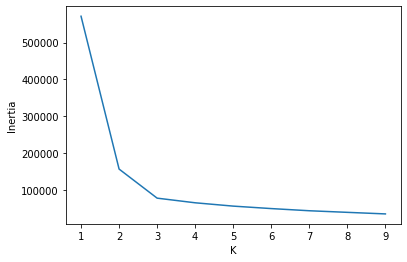

In [25]:
inertia_values = [KMeans(k).fit(darts).inertia_ for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

The elbow method isn’t perfect, but it performs reasonably well if the data is centered on $K$ distinct means. Of course, this assumes that our data clusters differ due to centrality.

However, in many instances, data clusters differ due to the density of the data points in space.

##Using density to discover clusters